#ESI Data

Goals: 
For each .fits file
- fits file -> numpy array image data (flips)
- read .list file to get labels
- compress to a .npz file
- predict with "heuristic"/Keras.predict() 
- make confusion matrix

##Imports and Load SPIT

Functions needed from SPIT
- get_prediction() from classify.py later
- read_fits() from io.py
- process_image() from preprocess.py
- flips() from preprocess.py
- classifier.py

In [0]:
import os
from google.colab import drive
from importlib import reload
import numpy as np

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
file_path = "/content/drive/My Drive/model_test"

In [0]:
!git clone https://github.com/pypeit/spit.git

Cloning into 'spit'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 884 (delta 9), reused 2 (delta 0), pack-reused 860
Receiving objects: 100% (884/884), 1.18 MiB | 1.56 MiB/s, done.
Resolving deltas: 100% (507/507), done.


In [0]:
%cd spit

/content/spit


In [0]:
!python setup.py develop

running develop
running egg_info
creating spit.egg-info
writing spit.egg-info/PKG-INFO
writing dependency_links to spit.egg-info/dependency_links.txt
writing top-level names to spit.egg-info/top_level.txt
writing manifest file 'spit.egg-info/SOURCES.txt'
writing manifest file 'spit.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/spit.egg-link (link to .)
Adding spit 0.1.dev0 to easy-install.pth file
Installing spit_png script to /usr/local/bin
Installing spit_train script to /usr/local/bin
Installing spit_classify_image script to /usr/local/bin

Installed /content/spit
Processing dependencies for spit==0.1.dev0
Finished processing dependencies for spit==0.1.dev0


In [0]:
from spit import classify as spit_classify
from spit import io as spit_io
from spit import preprocess as spit_p
from spit import classifier as spit_c
from spit import labels as spit_l

In [0]:
label_dict = spit_l.kast_label_dict() 
label_dict

OrderedDict([('bias_label', 0),
             ('science_label', 1),
             ('standard_label', 2),
             ('arc_label', 3),
             ('flat_label', 4)])

In [0]:
preproc_dict = spit_p.original_preproc_dict()
preproc_dict

{'cutoff_percent': 1.1,
 'image_height': 210,
 'image_width': 650,
 'img_shape': (210, 650),
 'img_size_flat': 136500,
 'num_channels': 1,
 'pad_const': 0}

In [0]:
classify_dict = spit_l.kast_classify_dict(label_dict)
classify_dict

{-1: 'unknown', 0: 'bias', 1: 'science', 2: 'standard', 3: 'arc', 4: 'flat'}

##Predictions on Kast-trained model (subset samples)

// Codes reference to make_standard() method in generate_pngs.py and Kast_Multi_images.ipynb


###Functions

In [0]:
def predict_one_image(images, classifier):
  
  ishape = list(images.shape)
  images = images.reshape(ishape+[1])
  
  prediction = classifier.model.predict(images)
  return prediction

In [0]:
def get_prediction(images_array, classifier, use_heuristics=False):
    """

    Returns
    -------
    value : int
      Most common value or -1, if it is not the majority
    results : list
      All of the values for each flipped image
    """
    from collections import Counter
    
    # Classify all 4
    results = []
    results.append(np.argmax(predict_one_image(images_array[0:1,:], classifier)))
    results.append(np.argmax(predict_one_image(images_array[1:2,:], classifier)))
    results.append(np.argmax(predict_one_image(images_array[2:3,:], classifier)))
    results.append(np.argmax(predict_one_image(images_array[3:4,:], classifier)))
    resultsCounter = Counter(results)

    # Heuristics
    if use_heuristics:
        if results.count(2) >= 2:
            value = 2
        elif results.count(1) >= 2:
            value = 1
        else:
            value, _ = resultsCounter.most_common()[0]
    else:  # Majority rules
        value, n_occur = resultsCounter.most_common()[0]
        if n_occur <= 2:
            value = -1
    # Return
    return value, results

###Try one file

In [0]:
num = 1
file_name = 'esi{:04d}.fits'.format(num)
fits_file = file_path+file_name
data = spit_io.read_fits(fits_file)
image = spit_p.process_image(data, preproc_dict)
flip_images = spit_p.flips(image)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [0]:
image_array = list(flip_images)

In [0]:
images_array = np.array(image_array)

In [0]:
kast_model = spit_c.Classifier(label_dict, preproc_dict, classify_dict) 
kast_model.model = kast_model.load_model('best_model.h5', '/content/drive/My Drive/model_test/')

W0723 23:02:21.167455 140587101816704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 23:02:22.265986 140587101816704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 23:02:22.268431 140587101816704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [0]:
value, results = get_prediction(images_array, kast_model, use_heuristics=True)

In [0]:
value

2

In [0]:
results

[0, 2, 0, 2]

###All 26 images with heuristics

In [0]:
kast_model = spit_c.Classifier(label_dict, preproc_dict, classify_dict) 
kast_model.model = kast_model.load_model('best_model.h5', '/content/drive/My Drive/model_test/')

W0724 19:59:43.443850 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 19:59:45.280623 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 19:59:45.288196 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [0]:
values=[]
results=[]

In [0]:
for num in range(1,27):
  file_name = 'esi{:04d}.fits'.format(num)
  print('Working on file %s ' %file_name)
  fits_file = file_path+file_name
  data = spit_io.read_fits(fits_file)
  image = spit_p.process_image(data, preproc_dict)
  flip_images = spit_p.flips(image)
  images_array = np.array(list(flip_images))
  value, result = get_prediction(images_array, kast_model, use_heuristics=True)
  values.append(value)
  results.append(result)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [0]:
values

[2, 3, 1, 2, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1]

In [0]:
results

[[0, 2, 0, 2],
 [3, 3, 3, 3],
 [1, 1, 1, 3],
 [0, 2, 0, 2],
 [1, 1, 1, 1],
 [4, 1, 3, 3],
 [1, 1, 3, 1],
 [1, 1, 3, 1],
 [4, 1, 3, 1],
 [4, 1, 3, 3],
 [4, 1, 3, 3],
 [3, 1, 1, 1],
 [3, 1, 3, 1],
 [3, 1, 3, 3],
 [3, 3, 3, 3],
 [3, 1, 3, 3],
 [1, 3, 1, 1],
 [1, 3, 3, 3],
 [1, 3, 1, 1],
 [1, 1, 1, 1],
 [3, 3, 1, 3],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [3, 1, 1, 1],
 [3, 1, 1, 3]]

###Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
val_true = [0, 3, 3, 0, 4, 4, 4, 4, 4, 4, 4, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2]

In [0]:
cm = confusion_matrix(val_true, values)

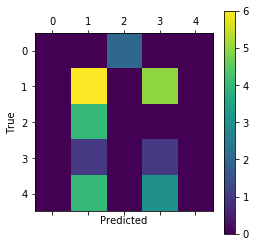

In [0]:
from matplotlib import pyplot as plt
# Plot the confusion matrix as an image.
plt.matshow(cm)

num_classes = 5
# Make various adjustments to the plot.
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()

###All 26 images without heuristics (ignore)

In [0]:
kast_model = spit_c.Classifier(label_dict, preproc_dict, classify_dict) 
kast_model.model = kast_model.load_model('best_model.h5', '/content/drive/My Drive/model_test/')

W0724 19:59:43.443850 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 19:59:45.280623 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0724 19:59:45.288196 139656796874624 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [0]:
values_2=[]
results_2=[]

In [0]:
for num in range(1,27):
  file_name = 'esi{:04d}.fits'.format(num)
  print('Working on file %s ' %file_name)
  fits_file = file_path+file_name
  data = spit_io.read_fits(fits_file)
  image = spit_p.process_image(data, preproc_dict)
  flip_images = spit_p.flips(image)
  images_array = np.array(list(flip_images))
  value, result = get_prediction(images_array, kast_model)
  values_2.append(value)
  results_2.append(result)

Working on file esi0001.fits 


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Working on file esi0002.fits 
Working on file esi0003.fits 
Working on file esi0004.fits 
Working on file esi0005.fits 
Working on file esi0006.fits 
Working on file esi0007.fits 
Working on file esi0008.fits 
Working on file esi0009.fits 
Working on file esi0010.fits 
Working on file esi0011.fits 
Working on file esi0012.fits 
Working on file esi0013.fits 
Working on file esi0014.fits 
Working on file esi0015.fits 
Working on file esi0016.fits 
Working on file esi0017.fits 
Working on file esi0018.fits 
Working on file esi0019.fits 
Working on file esi0020.fits 
Working on file esi0021.fits 
Working on file esi0022.fits 
Working on file esi0023.fits 
Working on file esi0024.fits 
Working on file esi0025.fits 
Working on file esi0026.fits 


In [0]:
values_2

[-1,
 3,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 3,
 3,
 3,
 1,
 3,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 -1]

In [0]:
results_2

[[0, 2, 0, 2],
 [3, 3, 3, 3],
 [1, 1, 1, 3],
 [0, 2, 0, 2],
 [1, 1, 1, 1],
 [4, 1, 3, 3],
 [1, 1, 3, 1],
 [1, 1, 3, 1],
 [4, 1, 3, 1],
 [4, 1, 3, 3],
 [4, 1, 3, 3],
 [3, 1, 1, 1],
 [3, 1, 3, 1],
 [3, 1, 3, 3],
 [3, 3, 3, 3],
 [3, 1, 3, 3],
 [1, 3, 1, 1],
 [1, 3, 3, 3],
 [1, 3, 1, 1],
 [1, 1, 1, 1],
 [3, 3, 1, 3],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [3, 1, 1, 1],
 [3, 1, 1, 3]]

###Look at some pngs

In [0]:
from spit import generate_pngs
write_path = '/content/drive/My Drive/ESI_PNG/'
generate_pngs.make_standard(file_path+'esi0014.fits', write_path, [0,-1], 0, preproc_dict) 

Processing FITS file esi0014.fits


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


##Predict on Kast-trained model with Keras (subset samples)

In [0]:
from tensorflow import keras

In [0]:
spit_path = "/content/drive/My Drive"

In [0]:
test = np.load(os.path.join(spit_path, 'Kast', 'kast_test.npz'))

In [0]:
test_images = test['images']
test_labels = test['labels']

In [0]:
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(label_dict))

In [0]:
kast_model = spit_c.Classifier(label_dict, preproc_dict, classify_dict)

W0812 17:30:42.550112 140173069850496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
kast_model.model = kast_model.load_model('/kast_keras_best_model.h5', file_path)

W0812 17:30:46.910071 140173069850496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0812 17:30:46.912853 140173069850496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
predictions = kast_model.model.predict(test_images)
predictions

array([[5.73008745e-23, 6.36862341e-10, 4.99791119e-22, 9.99465644e-01,
        5.34321414e-04],
       [2.40022449e-21, 2.11701536e-06, 1.24726809e-15, 5.73569275e-02,
        9.42640960e-01],
       [3.35388519e-16, 4.15109366e-01, 1.13183887e-06, 5.84889412e-01,
        1.08797273e-07],
       [1.15521503e-16, 1.26918212e-01, 1.70147601e-07, 8.73080969e-01,
        6.11041003e-07],
       [7.79973283e-17, 7.71781504e-02, 7.35355385e-08, 9.22820687e-01,
        1.07916742e-06],
       [6.28665343e-25, 5.93983474e-10, 9.93134964e-18, 3.39151360e-03,
        9.96608496e-01],
       [5.83139392e-25, 5.65150593e-10, 2.31551081e-17, 2.39030051e-04,
        9.99760926e-01],
       [1.70559932e-24, 3.74107945e-09, 9.90100915e-17, 9.82835423e-04,
        9.99017119e-01],
       [1.01116277e-21, 1.63825950e-06, 2.15159819e-17, 2.14544624e-01,
        7.85453737e-01],
       [1.68675376e-28, 1.44038393e-04, 1.80774913e-17, 2.29381956e-03,
        9.97562170e-01],
       [9.86067454e-25, 1.6518

In [0]:
pred = []
for p in enumerate(predictions):
  # index of loop
  i = p[0]
  # particular prediction array for this image
  p_array = p[1]
  # find and append prediction
  maxIndex = np.where(p_array == np.amax(p_array))
  pred.append(maxIndex[0][0])

In [0]:
# plot_confusion_matrix(test_labels, pred, )
print(label_dict)
classes = []
for label in label_dict:
  if '_label' in label:
    label = label.replace('_label','')
  classes.append(label)
print(classes)
# classes = {x.replace('_label', '') for x in classes}
# print(classes)

OrderedDict([('bias_label', 0), ('science_label', 1), ('standard_label', 2), ('arc_label', 3), ('flat_label', 4)])
['bias', 'science', 'standard', 'arc', 'flat']


Confusion matrix, without normalization
[[ 0  8  4  0  0]
 [ 0 23  0  3  0]
 [ 0  2  0  2  0]
 [ 0  1  0 11  0]
 [ 0  2  0  5 14]]


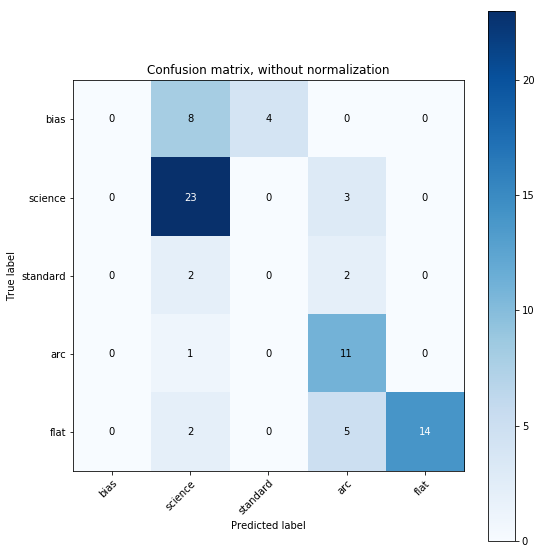

In [0]:
plot_confusion_matrix(val_true, pred, classes)

##Read esi.list

- Read .list file
- Traverse ECH label & class label and move into folders named by classes
- Split each class into train/valid/test

In [0]:
# file path that contains esi.list wanted
data_dpath = '/content/drive/My Drive/ESI/2005-Aug-04'

In [0]:
cd '/content/drive/My Drive/ESI/2005-Aug-04'

/content/drive/My Drive/ESI/2005-Aug-04


In [0]:
# use astropy to read esi.list
from astropy.io import ascii
data = ascii.read(data_dpath+'/esi.list')
data

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15
int64,str7,int64,str12,int64,str3,str4,int64,float64,int64,int64,str1,float64,int64,int64
1,esi0002,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
2,esi0003,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
3,esi0004,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
4,esi0005,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
5,esi0006,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
6,esi0007,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
7,esi0008,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
8,esi0009,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0
9,esi0010,1,Bias,-1,ECH,ZRO,1,0.75,0,0,C,1.0,0,0


Reading Logic:

- if col6=='ECH' --> Read col7 to see five classes
- else if col6!='ECH' && col7=='ZRO' --> still to Bias

In [0]:
# where to save the new data
save_dir = '/content/drive/My Drive/ESI_DATA'

In [0]:
from shutil import copyfile
curr_dir = os.getcwd()
curr_dir

'/content/drive/My Drive/ESI/2005-Aug-04'

In [0]:
# prefix needed for saving (there are cases that fits files have same names in different folders)
time_pre = '2005-Aug-04_'

In [0]:
# methods that redirect data from original folders
# the name of file in esi.list contains '.fits' e.g. 'esi0001.fits'
# param:
# data: data that read from esi.list by astropy
# src_dir: source directory, where the fits files are saved
# dst_dir: destination directory, where we need to save different classes folders

def redirect_data(data, src_dir, dst_dir):
  for i in range(len(data)):
    if data['col6'][i] == 'ECH':
      if data['col7'][i] == 'ZRO':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/bias/'+time_pre+data['col2'][i]+'.gz')
      elif data['col7'][i] == 'IFLT':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/flat/'+time_pre+data['col2'][i]+'.gz')
      elif data['col7'][i] == 'DFLT':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/flat/'+time_pre+data['col2'][i]+'.gz')
      elif data['col7'][i] == 'ARC':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/arc/'+time_pre+data['col2'][i]+'.gz')
      elif data['col7'][i] == 'STD':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/standard/'+time_pre+data['col2'][i]+'.gz')
      elif data['col7'][i] == 'OBJ':
        copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/science/'+time_pre+data['col2'][i]+'.gz')
    elif data['col6'][i] != 'ECH' and data['col7'][i] == 'ZRO':
      copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/bias/'+time_pre+data['col2'][i]+'.gz')
    else:
      copyfile(src_dir+'/'+data['col2'][i]+'.gz', dst_dir+'/err_'+time_pre+data['col2'][i]+'.gz')
      
  return

In [0]:
# methods that redirect data from original folders
# the name of file in esi.list that does not contain '.fits' e.g. 'esi0001'
# param:
# data: data that read from esi.list by astropy
# src_dir: source directory, where the fits files are saved
# dst_dir: destination directory, where we need to save different classes folders

def redirect_data_fits(data, src_dir, dst_dir):
  for i in range(len(data)):
    if data['col6'][i] == 'ECH':
      if data['col7'][i] == 'ZRO':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/bias/'+time_pre+data['col2'][i]+'.fits.gz')
      elif data['col7'][i] == 'IFLT':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/flat/'+time_pre+data['col2'][i]+'.fits.gz')
      elif data['col7'][i] == 'DFLT':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/flat/'+time_pre+data['col2'][i]+'.fits.gz')
      elif data['col7'][i] == 'ARC':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/arc/'+time_pre+data['col2'][i]+'.fits.gz')
      elif data['col7'][i] == 'STD':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/standard/'+time_pre+data['col2'][i]+'.fits.gz')
      elif data['col7'][i] == 'OBJ':
        copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/science/'+time_pre+data['col2'][i]+'.fits.gz')
    elif data['col6'][i] != 'ECH' and data['col7'][i] == 'ZRO':
      copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'/bias/'+time_pre+data['col2'][i]+'.fits.gz')
    else:
      copyfile(src_dir+'/'+data['col2'][i]+'.fits.gz', dst_dir+'err_'+time_pre+data['col2'][i]+'.fits.gz')
      
  return

In [0]:
# file names in esi.list with '.fits'
redirect_data(data, curr_dir, save_dir)

In [0]:
# file names in esi.list without '.fits'
redirect_data_fits(data, curr_dir, save_dir)

##Split sets

This method will create folders called 'train' 'val' 'test' in the output folder that contains original classes.

Usage: https://pypi.org/project/split-folders/

In [0]:
pip install split-folders

In [0]:
data_dpath = '/content/drive/My Drive/ESI_DATA'

In [0]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [0]:
import split_folders

In [0]:
split_folders.ratio('ESI_DATA', output="ESI_DATA_SPLIT", ratio=(.7, .15, .15))

Copying files: 490 files [09:00,  1.29s/ files]


##Create .npz file for train/valid/test

In [0]:
# the file path that contains fits files
file_dpath = '/content/drive/My Drive/ESI_DATA_SPLIT/test'

In [0]:
cd '/content/drive/My Drive/ESI_DATA_SPLIT/test'

/content/drive/My Drive/ESI_DATA_SPLIT/test


In [0]:
import os
import gzip
from astropy.io import fits
import pdb
import numpy as np

In [0]:
images = [] 
labels = []
i = 0

#for itype in ['flat', 'arc', 'bias','standard','science']:
for file in os.listdir(file_dpath+'/science'+#itype):
  if i==4:
    i=0
    break
  # decompress and read fits files data out
  if file.endswith(".gz"):
    filename = file[:-3]
    image = open(file_dpath+'/'+itype+'/'+filename, "wb")
    with gzip.open(file_dpath+'/'+itype+'/'+file, "rb") as f:
      bindata = f.read()
      image.write(bindata)
      f.close()
    print('Working on file %s ' %filename)
    fits_file = file_dpath+'/'+itype+'/'+filename
    data = spit_io.read_fits(fits_file)
    image_data = spit_p.process_image(data, preproc_dict)
    images.append(image_data)
    image.close()
      
    if itype == 'bias':
      image_label = label_dict['bias_label']
    elif itype == 'science':
      image_label = label_dict['science_label']
    elif itype == 'standard':
      image_label = label_dict['standard_label']
    elif itype == 'arc':
      image_label = label_dict['arc_label']
    elif itype == 'flat':
      image_label = label_dict['flat_label']
    else:
      pdb.set_trace()
    labels.append(image_label)
  i = i+1
        
images_array = np.array(list(images))
images_labels = np.array(list(labels))

SyntaxError: ignored

In [0]:
images_array.shape

(16, 210, 650)

In [0]:
images_labels.shape

(16,)

In [0]:
ishape = list(images_array.shape)
images_array = images_array.reshape(ishape+[1])
images_array.shape

(16, 210, 650, 1)

In [0]:
 np.savez_compressed('balanced_test', images=images_array, labels=images_labels)

The following are methods to modify an existing .npz file

In [0]:
cd '/content/drive/My Drive/ESI_DATA_SPLIT'

/content/drive/My Drive/ESI_DATA_SPLIT


In [0]:
# if had one before load and modify

tmp_images = np.load('esi_validate.npz')['images']
tmp_labels = np.load('esi_validate.npz')['labels']

In [0]:
tmp_images.shape

(58, 210, 650, 1)

In [0]:
tmp_images = np.append(tmp_images, images_array, axis=0)

In [0]:
tmp_images.shape

(75, 210, 650, 1)

In [0]:
tmp_labels = np.append(tmp_labels, images_labels, axis=0)

In [0]:
tmp_labels.shape

(75,)

In [0]:
np.savez_compressed('esi_test_new', images=tmp_images, labels=tmp_labels)

## Train on Basic CNN

In [0]:
import tensorflow as tf
from tensorflow import keras
import os

In [0]:
esi_dpath = '/content/drive/My Drive/ESI_DATA_SPLIT'

In [0]:
train = np.load(os.path.join(esi_dpath, 'esi_train.npz'))

In [0]:
train_images = train['images']
train_labels = train['labels']

In [0]:
train_images.shape

(339, 210, 650, 1)

In [0]:
validate = np.load(os.path.join(esi_dpath, 'esi_validate.npz'))

In [0]:
valid_images = validate['images']
valid_labels = validate['labels']

In [0]:
esi = spit_c.Classifier(label_dict, preproc_dict, classify_dict)

W0813 04:48:02.286548 139673926203264 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
train_labels = keras.utils.to_categorical(train_labels, num_classes=len(label_dict))
valid_labels = keras.utils.to_categorical(valid_labels, num_classes=len(label_dict))

In [0]:
checkpoint=keras.callbacks.ModelCheckpoint(file_path+'/esi_best_model_full.h5', monitor='val_acc', save_best_only=True, mode='max')

In [0]:
result = esi.model.fit(train_images, train_labels, epochs=100, batch_size=32, 
                   validation_data=(valid_images, valid_labels), callbacks=[checkpoint]) 

Train on 339 samples, validate on 68 samples
Epoch 1/100
339/339 [==============================] - 14s 42ms/sample - loss: 613.8036 - acc: 0.5280 - val_loss: 0.3482 - val_acc: 0.8382
Epoch 2/100
339/339 [==============================] - 8s 24ms/sample - loss: 0.5185 - acc: 0.9204 - val_loss: 0.9075 - val_acc: 0.9853
Epoch 3/100
339/339 [==============================] - 4s 11ms/sample - loss: 0.1847 - acc: 0.9735 - val_loss: 1.2464 - val_acc: 0.9853
Epoch 4/100
339/339 [==============================] - 4s 11ms/sample - loss: 0.8394 - acc: 0.9440 - val_loss: 2.0463 - val_acc: 0.9265
Epoch 5/100
339/339 [==============================] - 4s 11ms/sample - loss: 0.4147 - acc: 0.9381 - val_loss: 5.3661 - val_acc: 0.8824
Epoch 6/100
339/339 [==============================] - 4s 11ms/sample - loss: 0.4061 - acc: 0.9469 - val_loss: 2.5170 - val_acc: 0.9706
Epoch 7/100
339/339 [==============================] - 4s 11ms/sample - loss: 0.2898 - acc: 0.9735 - val_loss: 1.5186 - val_acc: 0.9853


##Test Basic CNN

In [0]:
test = np.load(os.path.join(esi_dpath, 'balanced_test.npz'))

In [0]:
test_images = test['images']
test_labels = test['labels']

In [0]:
test_images.shape

(20, 210, 650, 1)

In [0]:
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(label_dict))

In [0]:
esi.model = esi.load_model('/esi_best_model_full.h5', file_path)

In [0]:
esi.model.evaluate(test_images, test_labels) 

75/75 [==============================] - 1s 9ms/sample - loss: 0.3540 - acc: 1.0000


[0.3539664888381958, 1.0]

In [0]:
best = spit_c.Classifier(label_dict, preproc_dict, classify_dict)

In [0]:
best.model = esi.load_model('/esi_best_model.h5', file_path)

In [0]:
best.model.evaluate(test_images, test_labels) 

75/75 [==============================] - 0s 5ms/sample - loss: 0.2484 - acc: 1.0000


[0.24837631940841676, 1.0]

##Acc. vs. loss plot

In [0]:
from spit import utils as spit_u

In [0]:
train_acc = result.history['acc']
valid_acc = result.history['val_acc']
train_loss = result.history['loss']
valid_acc = result.history['val_loss']

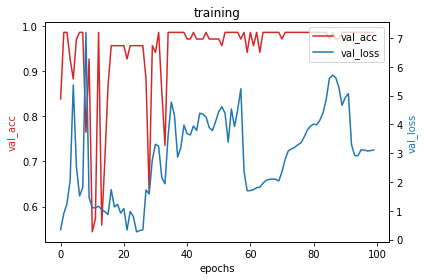

In [0]:
spit_u.display_training_trends(result, 'val_acc', 'val_loss')

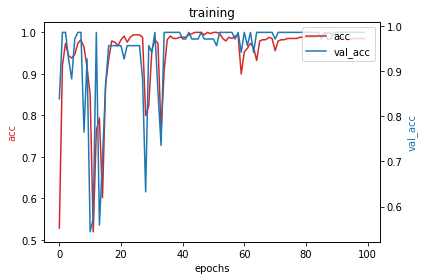

In [0]:
spit_u.display_training_trends(result, 'acc', 'val_acc')

##Confusion Matrix using heuristics in SPIT


In [0]:
values=[]
results=[]
for image in test_images:
  ishape = list(image.shape)
  image = image.reshape(ishape[:-1])
  #print(image.shape)
  flip_images = spit_p.flips(image)
  images_array = np.array(list(flip_images))
  value, result = get_prediction(images_array, esi, use_heuristics=True)
  values.append(value)
  results.append(result)

In [0]:
values, results

([2,
  2,
  2,
  2,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  1,
  2,
  4,
  4,
  4,
  4,
  4,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  0,
  1,
  0,
  1,
  3,
  0,
  0,
  0,
  0,
  3,
  2,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  3,
  1,
  1],
 [[4, 2, 2, 3],
  [4, 2, 2, 1],
  [4, 2, 2, 3],
  [4, 2, 2, 1],
  [4, 1, 1, 3],
  [4, 1, 1, 3],
  [4, 2, 2, 1],
  [4, 2, 2, 1],
  [4, 2, 2, 3],
  [4, 2, 2, 3],
  [4, 2, 2, 1],
  [4, 2, 2, 1],
  [4, 1, 2, 1],
  [4, 2, 2, 3],
  [4, 1, 3, 2],
  [4, 1, 2, 3],
  [4, 1, 2, 3],
  [4, 1, 2, 3],
  [4, 1, 2, 3],
  [3, 3, 1, 3],
  [3, 3, 1, 3],
  [3, 3, 1, 3],
  [3, 3, 1, 3],
  [3, 3, 1, 3],
  [3, 3, 2, 3],
  [3, 3, 1, 3],
  [3, 1, 3, 3],
  [3, 1, 3, 3],
  [3, 3, 3, 3],
  [3, 3, 1, 3],
  [0, 0, 3, 4],
  [0, 1, 1, 3],
  [0, 0, 0, 0],
  [0, 1, 1, 3],
  [0, 1, 3, 3],
  [0, 1, 0, 3],
  [0, 0, 0, 0],
  [0, 1, 0, 3],
  [0, 1, 0, 3],
  [2, 3, 1, 3],
  [2, 2, 2, 3],
  [2, 2, 2, 3

In [0]:
true_labels = test['labels']
cm = confusion_matrix(true_labels, values)

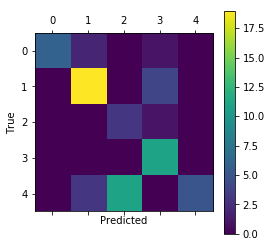

In [0]:
from matplotlib import pyplot as plt
# Plot the confusion matrix as an image.
plt.matshow(cm)

num_classes = 5
# Make various adjustments to the plot.
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()

##Confusion Matrix by keras.predict

In [0]:
val_true = test['labels']

In [0]:
predictions = esi.model.predict(test_images)
predictions

array([[1.5991602e-09, 1.6705200e-11, 3.2383088e-08, 9.9534236e-07,
        9.9999893e-01],
       [1.7146964e-09, 1.8184376e-11, 3.0899574e-08, 1.0281852e-06,
        9.9999893e-01],
       [1.6680045e-07, 1.7574939e-08, 1.4717050e-06, 2.6329659e-05,
        9.9997199e-01],
       [1.7812719e-09, 1.7256202e-11, 2.7232028e-08, 1.1279446e-06,
        9.9999881e-01],
       [2.1791069e-23, 1.9242508e-16, 3.9908096e-17, 1.0000000e+00,
        8.6526020e-22],
       [6.6462779e-25, 3.3098083e-18, 1.5705619e-18, 1.0000000e+00,
        3.6533288e-23],
       [1.7352920e-12, 1.7998528e-09, 1.2677199e-09, 1.0000000e+00,
        1.1615282e-11],
       [8.9735465e-18, 2.1807584e-11, 2.7929950e-12, 1.0000000e+00,
        3.7721739e-16],
       [2.1258314e-01, 2.0961149e-01, 1.8956518e-01, 1.9192295e-01,
        1.9631724e-01],
       [2.0852621e-01, 2.0221747e-01, 1.9622849e-01, 1.9549462e-01,
        1.9753319e-01],
       [2.0395540e-01, 1.9967572e-01, 1.9804342e-01, 1.9819011e-01,
        2.00

In [0]:
pred = []
for p in enumerate(predictions):
  # index of loop
  i = p[0]
  # particular prediction array for this image
  p_array = p[1]
  # find and append prediction
  maxIndex = np.where(p_array == np.amax(p_array))
  pred.append(maxIndex[0][0])

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    #fig, ax = plt.subplots()
    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    fig.tight_layout()
    return ax

In [0]:
# plot_confusion_matrix(test_labels, pred, )
print(label_dict)
classes = []
for label in label_dict:
  if '_label' in label:
    label = label.replace('_label','')
  classes.append(label)
print(classes)
# classes = {x.replace('_label', '') for x in classes}
# print(classes)

OrderedDict([('bias_label', 0), ('science_label', 1), ('standard_label', 2), ('arc_label', 3), ('flat_label', 4)])
['bias', 'science', 'standard', 'arc', 'flat']


Confusion matrix, without normalization
[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 4 0 0]
 [0 0 0 4 0]
 [0 0 0 0 4]]


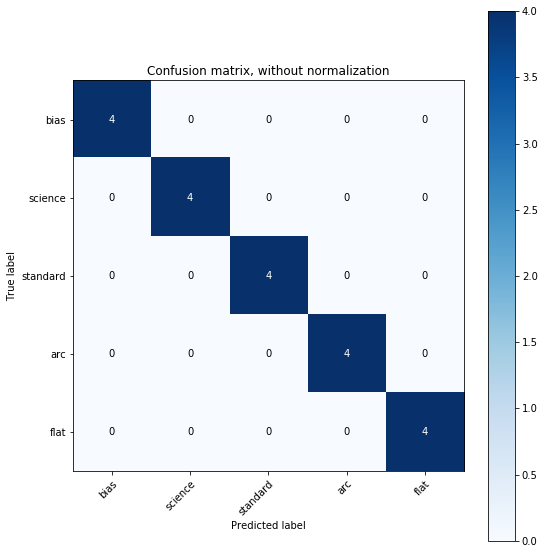

In [0]:
plot_confusion_matrix(val_true, pred, classes)

##Train ESI on DenseNet

###Preparation

In [0]:
!pip install tensorflow==2.0.0b1

In [0]:
# imports
import numpy as np
import os

from importlib import reload
from pkg_resources import resource_filename
from google.colab import drive
import imageio

In [0]:
drive.mount('/content/drive/')

In [0]:
!git clone https://github.com/pypeit/spit.git

In [0]:
!git checkout new_models

In [0]:
!python setup.py develop

In [0]:
# imports
from importlib import reload

from spit import image_loader
from spit import labels as spit_l
from spit import preprocess as spit_p
from spit import classifier as c
from spit import utils
from spit import classify as spit_classify
from spit import io as spit_io

In [0]:
import tensorflow as tf
from tensorflow import keras

###Build densenet

In [0]:
# need to add compression to either block, transition, or both to get it to be BC

def dense_block(model):
  
  # 1x1 convolution bottleneck
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETERS: GROWTH RATE AND DROPOUT RATE ####
  model.add(keras.layers.Conv2D(growth_rate*filters, kernel_size=1))
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  # 3x3 dense convolution
  
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.ReLU())
  #### HYPERPARAMETER ####
  model.add(keras.layers.Conv2D(filters, kernel_size=3))
  #### HYPERPARAMETER ####
  model.add(keras.layers.Dropout(rate=dropout_rate))
  
  return

def transition_layer(model):
  model.add(keras.layers.BatchNormalization())       #   x = Batch_Normalization(x, training=self.training, scope=scope+'_batch1')
  model.add(keras.layers.ReLU())                     #   x = Relu(x)
  
  model.add(keras.layers.Conv2D(filters, kernel_size=1))
  
  model.add(keras.layers.Dropout(rate=dropout_rate)) #   x = Drop_out(x, rate=dropout_rate, training=self.training)
  
  model.add(keras.layers.AveragePooling2D(pool_size=(2,2), strides=2))
  return

In [0]:
#### DENSE NET ARCHITECTURE #####
#
# CONV --> BLOCK --> TRANSITION --> BLOCK --> TRANSITION --> BLOCK --> POOL --> SOFTMAX
#
# BLOCK:
# BatchNorm --> ReLu --> Conv (1x1) --> DropOut --> BatchNorm --> ReLu --> Conv (3x3) --> DropOut --> output
#

model = keras.Sequential()

# hyperparameters
filters = 64
dropout_rate = .2
theta = .5
growth_rate = 4

# add a conv layer
model.add(keras.layers.Conv2D(filters, kernel_size=7, strides=(2, 2), padding='valid', activation='relu', 
                            input_shape = (210, 650, 1)))

# pool like in tf simple implementation
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='valid'))

# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add transition
transition_layer(model)
# add block
dense_block(model)
# add pool
model.add(keras.layers.GlobalAveragePooling2D())
# add flatten
model.add(keras.layers.Flatten())

# Produce 0-1 probabilities with softmax
model.add(keras.layers.Dense(5, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

###methods

In [0]:
#   os.environ['SPIT_PATH'] = "/content/drive/My Drive/Colab Notebooks/SPIT_DATA"
#   os.environ['SAVE_PATH'] = "/content/drive/My Drive/Colab Notebooks/"

  # might need to add subset
  def _train(epochs, batch_size, subset_percent=None, train_images=None, train_labels=None, validation_data=None, steps_per_epoch=None, validation_freq=1, test_model=None, spit_path=os.getenv('SPIT_PATH'), save_path=os.getenv('SAVE_PATH')):
    """

    Trains the classifier with given images, labels, and training parameters.

    Parameters:

    :param epochs:
      Number of epochs of the training. 
      Must be an integer value.

    :param batch_size:
      Size of the training batches formed in the process. 
      Must be an integer value.

    :param save_path:
      Path to where the best model will be saved.

    :param train_images:
       Set of images for model to train on.
       Assume this is a numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param train_labels:
      Set of test labels corresponding to test images.
      Assume this is a rank 1 array with (batch_size, ) as its dimensions.

    :param validation_data:
      Data to be used for the validation set. 
      Assume this is a tuple with (images, labels) with same dimensions as train_images, train_labels.
      If None is specified, validation_data will be None.

    :param steps_per_epoch:
      Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
      Assume this is an integer value. If None is specified, this will be None.  

    :param validation_freq:
      Specifies how many training epochs to run before a new validation run is performed.
      Assume this is an integer value or a collection containing the epochs at which to run validation (ie [1,2,10]).

    :param test_model:
      An alternative choice for model to train on. Assume None.

    :param spit_path & param save_path:
      Path to the spit images and where the model will be saved respectively.
      ***Environmental variables must be set by caller or the path must be passed manually.***

    Returns:
    :returns history:
      Tensorflow History object containing loss and accuracy data over the training.

    """
    # choose the model
    if test_model is None:
      model = test_model
    else:
      model = test_model

    # if None is passed, then use the kast images
    if train_images is None or train_labels is None:
      # load training set
      train = np.load(os.path.join(spit_path, 'Kast', 'kast_train.npz'))
      train_images = train['images']
      train_labels = train['labels']

      # load validation set
      validate = np.load(os.path.join(spit_path, 'Kast', 'kast_validate.npz'))
      v_images = validate['images']
      v_labels = validate['labels']

      validation_data = (v_images, v_labels)

    # change to categorical and make subsets
    if validation_data is not None:
      valid_images, valid_labels = validation_data
      if subset_percent is not None:
        valid_images, valid_labels = split_array(valid_images, valid_labels, subset_percent)
      valid_labels = keras.utils.to_categorical(valid_labels, num_classes=len(label_dict))
      validation_data = (valid_images, valid_labels)

    if train_images is not None and train_labels is not None:
      if subset_percent is not None:
        train_images, train_labels = split_array(train_images, train_labels, subset_percent)
      train_labels = keras.utils.to_categorical(train_labels, num_classes=len(label_dict))

    # checkpoint to track best model
    checkpoint=keras.callbacks.ModelCheckpoint(save_path+'best_model_esi.h5', monitor='val_accuracy', save_best_only=True, mode='max')

    # train the model
    history = model.fit(
          train_images, 
          train_labels, 
          epochs=epochs, 
          batch_size=batch_size,
          validation_data=validation_data,
          steps_per_epoch=steps_per_epoch,
          validation_freq=validation_freq,
          callbacks=[checkpoint]
    )
    
    # save loss and accuracy data
    keys = history.history
    np.savez_compressed('history_esi.npz', loss=keys['loss'], accuracy=keys['accuracy'], val_loss=keys['val_loss'], val_accuracy=keys['val_accuracy'])
    
    return history

  import math

  def split_array(images, labels, subset_percent):
    """
    Splits dataset based on a percentage value.

    Parameters:
    :param images:
      Images from a dataset to be trained on.
      4-D Numpy array with (batch_size, width, height, num_channels) as its dimensions.

    :param labels:
      Labels from a dataset to be trained on.
      Rank 1 Numpy array with (batch_size,) as its dimensions.

    :param subset_percent:
      Float value determining percentage of subset to remain.

    Returns:
    :returns split_images:
      Numpy array containing a fraction of the initial images parameter (batch_size*subset_percent)

    :returns split_labels:
      Numpy array containing a fraction of the initial labels parameter (batch_size*subset_percent)
    """
    split_images = []
    split_labels = []
    
    # get all unique labels
    uni_lbls = np.unique(labels)
    
    # find all instances of labels and subset based on that
    for uni_lbl in uni_lbls:
      idx = np.where(labels==uni_lbl)[0]
      # 0 : len(idx)*subset_percent
      lower = 0
      upper = int(math.floor(len(idx)*subset_percent))
      split_images.extend(images[idx[lower:upper]])
      split_labels.extend(labels[idx[lower:upper]])
    return np.asarray(split_images), np.asarray(split_labels)

In [0]:
def load_model(file_name, file_path):
  '''
  :param file_name: The model name. Should be a string 'blah.h5'
         file_path: The path that the user would like to save to.
                    In the form of 'blah/foo/bar/'
  :return: the model loaded
  '''

  loaded_model = keras.models.load_model(file_path+file_name)
  return loaded_model

In [0]:
def predict_one_image(images, model):
  
  ishape = list(images.shape)
  images = images.reshape(ishape+[1])
  
  prediction = model.predict(images)
  return prediction

In [0]:
from matplotlib import pyplot as plt

def display_training_trends(history, key1, key2, title='training'):
    """
    Display the graphs of loss/accuracy during training
    
    :param history:
        Tensorflow History object or Numpy Decompressed File object.
    :param key1:
        Key contained within history object that user can provide to plot as compared with other keys.
        Assume key is a string contained in the history object.
    :param key2:
        Key contained within history object that user can provide to plot as compared with other keys.
        Assume key is a string contained in the history object.
    :param title:
        Title of the graph. If caller doesn't specify, use default of 'training'.
    """
    h = None
    if  'tensorflow' in str(type(history)):
      h = history.history
      print("h is history.history")
    else:
      h = history
      print("h is history")
    print(h)
    # make subplots
    fig, ax1 = plt.subplots()

    # set title of graph
    plt.title(title) 

    # set x label
    color = 'tab:red'
    ax1.set_xlabel('epochs')

    # plot first key
    ax1.set_ylabel(key1, color=color)  # we already handled the x-label with ax1
    lns1 = ax1.plot(h[key1], color=color, label = key1) # maybe improve labeling 
    ax1.tick_params(axis='y')

    color = 'tab:blue'
    legend_loc = 'best'

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  

    # plot second key
    ax2.set_ylabel(key2, color=color)  # we already handled the x-label with ax1
    lns2 = ax2.plot(h[key2], color=color, label = key2)
    ax2.tick_params(axis='y') #labelcolor=color

    # legend for two axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=legend_loc)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

###Train

In [0]:
os.environ['SPIT_PATH'] = "/content/drive/My Drive/ESI_DATA_SPLIT"
os.environ['SAVE_PATH'] = "/content/drive/My Drive/"

In [0]:
label_dict = spit_l.kast_label_dict()
preproc_dict = spit_p.original_preproc_dict()
classify_dict = spit_l.kast_classify_dict(label_dict)

In [0]:
train = np.load(os.path.join(os.getenv('SPIT_PATH'), 'esi_train.npz'))
train_images = train['images']
train_labels = train['labels']

# load validation set
validate = np.load(os.path.join(os.getenv('SPIT_PATH'), 'esi_validate.npz'))
v_images = validate['images']
v_labels = validate['labels']

validation_data = (v_images, v_labels)

In [0]:
history = _train(epochs=100, batch_size=32, test_model=model, train_images=train_images, train_labels=train_labels, validation_data=validation_data)

###Test

In [0]:
best_model = keras.models.load_model(os.environ['SAVE_PATH']+'best_model_esi.h5')
test = np.load(os.path.join(os.environ['SPIT_PATH'], 'esi_test.npz'))
test_images = test['images']
test_labels = test['labels']
test_labels = keras.utils.to_categorical(test_labels, num_classes=len(label_dict))
best_model.evaluate(test_images, test_labels) 

##DenseNet Confusion Matrix

In [0]:
val_true = test['labels']

In [0]:
predictions = best_model.predict(test_images)
predictions

array([[2.26811826e-04, 8.30081917e-05, 1.76529502e-05, 8.10251944e-03,
        9.91569996e-01],
       [2.25419339e-04, 7.85554803e-05, 1.71641568e-05, 6.42185658e-03,
        9.93257046e-01],
       [9.59004101e-04, 2.52080150e-04, 5.28898381e-05, 7.44084502e-03,
        9.91295099e-01],
       [9.13481170e-04, 2.44308292e-04, 5.10560931e-05, 7.52488384e-03,
        9.91266310e-01],
       [8.89449380e-04, 2.38612643e-04, 4.98858790e-05, 7.49724032e-03,
        9.91324782e-01],
       [1.87849146e-04, 6.46183107e-05, 1.47914961e-05, 5.61864628e-03,
        9.94114101e-01],
       [1.43045545e-04, 5.38514105e-05, 1.25613678e-05, 5.54562965e-03,
        9.94244874e-01],
       [1.47491999e-04, 5.49727374e-05, 1.27830372e-05, 5.54469274e-03,
        9.94240046e-01],
       [4.29859829e-05, 1.80232910e-05, 5.02999364e-06, 3.43106571e-03,
        9.96502876e-01],
       [4.24150239e-05, 1.84985511e-05, 5.25711539e-06, 4.37145401e-03,
        9.95562434e-01],
       [1.15452138e-04, 4.2729

In [0]:
pred = []
for p in enumerate(predictions):
  # index of loop
  i = p[0]
  # particular prediction array for this image
  p_array = p[1]
  # find and append prediction
  maxIndex = np.where(p_array == np.amax(p_array))
  pred.append(maxIndex[0][0])

In [0]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
# plot_confusion_matrix(test_labels, pred, )
print(label_dict)
classes = []
for label in label_dict:
  if '_label' in label:
    label = label.replace('_label','')
  classes.append(label)
print(classes)
# classes = {x.replace('_label', '') for x in classes}
# print(classes)

OrderedDict([('bias_label', 0), ('science_label', 1), ('standard_label', 2), ('arc_label', 3), ('flat_label', 4)])
['bias', 'science', 'standard', 'arc', 'flat']


Confusion matrix, without normalization
[[12  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  0  4  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0 21]]


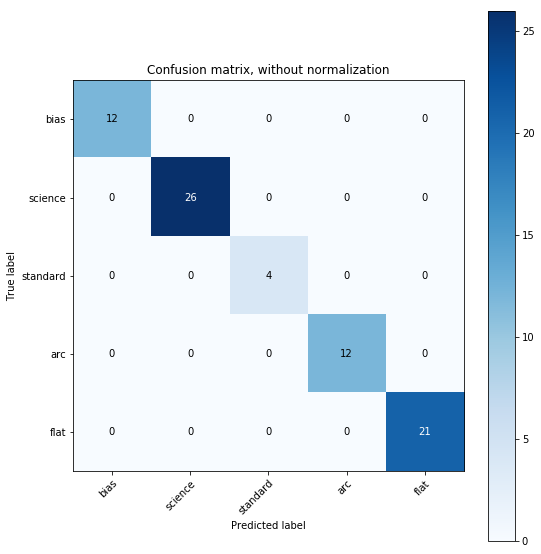

In [0]:
plot_confusion_matrix(val_true, pred, classes)